In [1]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence'
sys.path.append(my_path)
os.listdir(my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['dataTorchTransformLoad.py',
 'Resnet.py',
 'README.md',
 'VS_NET.py',
 '02_CIFAR+Resnet _Gradcam.ipynb',
 'QuizDNN.py',
 'EVA5 Assignment 9a',
 'dataAlbumentationLoad.py',
 '03_LR_Finder_CIFAR_RESNET_CAM.ipynb',
 'Test_Train.py',
 '03_LR_Finder_CIFAR_RESNET_CAM - V2.ipynb',
 'outputs',
 '__pycache__',
 'Plots.py',
 'GradCam.py',
 'grid_image.png',
 'best_model.pt',
 'Test_Train_OCP.py',
 '01-Super-convergence.ipynb']

In [2]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
import sys
import random
import matplotlib


# import for all the modular codes
import VS_NET
import Test_Train
import Test_Train_OCP
import Plots
import dataTorchTransformLoad as dtl
import Resnet
import GradCam
import Resnet
import dataAlbumentationLoad as dal
import GradCam
from GradCam import GradCAM, visualize_cam, save_misclassified, download_img_pil,pil_img_transform
from Plots import plot_misclassified,imshow


In [3]:
my_path

'/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence'

In [4]:
# def imshow(img):
#     # img = img / 2 + 0.5     # unnormalize
#     img[0] = img[0]*0.24703223 + 0.49139968
#     img[1] = img[1]*0.24348513 + 0.48215841
#     img[2] = img[2]*0.26158784 + 0.44653091
#     npimg = img.numpy()
#     image = np.transpose(npimg, (1, 2, 0))
#     plt.imshow(image)
#     plt.grid(b=None)
#     return image

def imshow1(img,c = "" ):
  #img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  fig = plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
  plt.title(c)
  plt.grid(b=None)
  plt.savefig(my_path+'/grid_image.png')

In [5]:

#initializers 
dropout_value = 0.05
num_splits=2
start_epoch=0
EPOCHS = 24
EPOCHS1 = 50
input_ch=3
best_acc = 85

metric_values = {}
models={}

batch_size_GPU=512
batch_size_CPU=16

model_save_path = my_path+"/best_model.pt"


In [6]:
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transform = dal.AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1 )
                                       ])
# # Test Phase transformations
test_transform = dal.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [7]:
# Transforms

transforms_cifar_train = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomRotation((-5.0, 5.0),fill=1), 
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                           transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])
transforms_cifar_test = transforms.Compose([
                                          #  transforms.Resize((28, 28)),
                                          #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        #   transforms.RandomRotation((-5.0, 5.0), fill=(1,)), 
                                        #   transforms.RandomHorizontalFlip(0.3),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                              [0.49139968, 0.48215841, 0.44653091], 
                                              [0.24703223, 0.24348513, 0.26158784]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                          #  transforms.RandomErasing()
                                          # Note the difference between (0.1307) and (0.1307,)
                                          ])

In [8]:
# download data

train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms_cifar_train)
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms_cifar_test) 

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [10]:
len(test_loader), len(train_loader)

(20, 98)

In [11]:
10000/512, 50000/512

(19.53125, 97.65625)

In [12]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
train_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
    #print(vars(train_set))
print("Shape : ", train_set.data.shape)
print("Mean : ",train_set.data.mean(axis=(0,1,2))/255)
print("Std : ",train_set.data.std(axis=(0,1,2))/255)
print("Min : ",train_set.data.min(axis=(0,1,2))/255)
print("Max : ",train_set.data.max(axis=(0,1,2))/255)

Files already downloaded and verified
Shape :  (50000, 32, 32, 3)
Mean :  [0.49139968 0.48215841 0.44653091]
Std :  [0.24703223 0.24348513 0.26158784]
Min :  [0. 0. 0.]
Max :  [1. 1. 1.]


<Figure size 432x288 with 0 Axes>

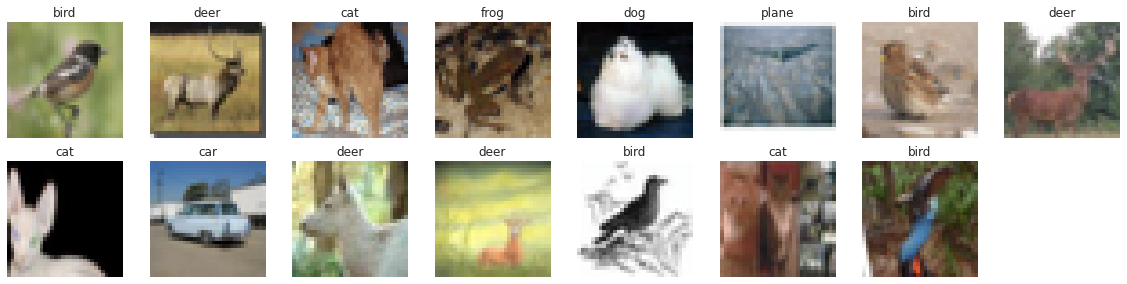

In [14]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# plt.style.use('dark_background')
figure = plt.figure()
plt.figure(figsize=(20,20))
num_of_images = 16
for index in range(1, num_of_images):
    plt.subplot(8, 8, index)
    plt.axis('off')
    plt.title(classes[labels[index].item()])
    imshow(images[index])

#RESNET

In [15]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Resnet.ResNet18().to(device)

In [16]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


# LR Finder

In [ ]:
# !pip install torch_lr_finder
from torch_lr_finder import LRFinder

model = model
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=1e-05,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=98 ,step_mode="exp")


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.79E-03


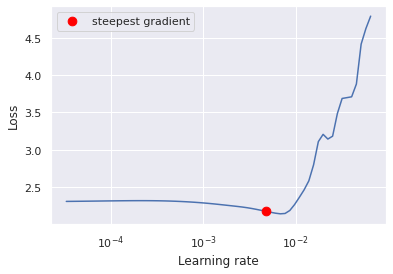

(<matplotlib.axes._subplots.AxesSubplot at 0x7fd8613df278>,
 0.004790847768206475)

In [ ]:
lr_finder.plot(log_lr=True)

In [ ]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
lr_finder.reset()

# Model Run

In [17]:
ideal_lr=0.0001

In [18]:
# LR Finder

# Uses Step lr to change the learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9,nesterov=False)
scheduler = StepLR(optimizer, step_size=2, gamma=1.7)

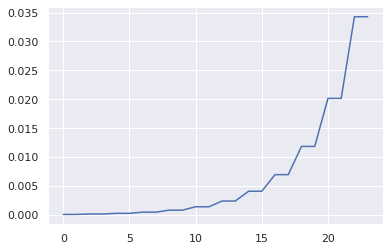

In [31]:
lr_list =[]
for i in range(EPOCHS):
  # print('EPOCH',i)
  # print(optimizer.param_groups[0]['lr'])
  lr_list.append(optimizer.param_groups[0]['lr'])
  optimizer.step()
  scheduler.step()
plt.plot(lr_list) 

In [19]:
exp_name = 'Resnet'

trainer = Test_Train_OCP.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
train_metric, test_metric,learning_rate = trainer.train(l1_lambda=0, l2_lambda=0)

# save the metrics in dictionary
metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
learning rate  0.0001


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=2.167444944381714 Batch_id=97 Accuracy=16.68: 100%|██████████| 98/98 [00:54<00:00,  1.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1268, Accuracy: 2274/10000 (22.74%)

emptying the cache
EPOCH: 1
learning rate  0.0001


Loss=2.011415719985962 Batch_id=97 Accuracy=23.90: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.0000, Accuracy: 2802/10000 (28.02%)

EPOCH: 2
learning rate  0.00017


Loss=1.9447898864746094 Batch_id=97 Accuracy=28.78: 100%|██████████| 98/98 [00:56<00:00,  1.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8603, Accuracy: 3294/10000 (32.94%)

EPOCH: 3
learning rate  0.00017


Loss=1.7580289840698242 Batch_id=97 Accuracy=33.33: 100%|██████████| 98/98 [00:56<00:00,  1.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7392, Accuracy: 3712/10000 (37.12%)

EPOCH: 4
learning rate  0.00028900000000000003


Loss=1.6923915147781372 Batch_id=97 Accuracy=37.57: 100%|██████████| 98/98 [00:56<00:00,  1.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6069, Accuracy: 4102/10000 (41.02%)

EPOCH: 5
learning rate  0.00028900000000000003


Loss=1.5724459886550903 Batch_id=97 Accuracy=41.06: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5206, Accuracy: 4359/10000 (43.59%)

EPOCH: 6
learning rate  0.0004913000000000001


Loss=1.4702577590942383 Batch_id=97 Accuracy=44.56: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4367, Accuracy: 4694/10000 (46.94%)

EPOCH: 7
learning rate  0.0004913000000000001


Loss=1.322736382484436 Batch_id=97 Accuracy=48.03: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3247, Accuracy: 5136/10000 (51.36%)

EPOCH: 8
learning rate  0.0008352100000000001


Loss=1.2068307399749756 Batch_id=97 Accuracy=51.59: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2457, Accuracy: 5458/10000 (54.58%)

EPOCH: 9
learning rate  0.0008352100000000001


Loss=1.199836015701294 Batch_id=97 Accuracy=55.11: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2274, Accuracy: 5502/10000 (55.02%)

EPOCH: 10
learning rate  0.001419857


Loss=1.0873774290084839 Batch_id=97 Accuracy=57.82: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1563, Accuracy: 5842/10000 (58.42%)

emptying the cache
EPOCH: 11
learning rate  0.001419857


Loss=1.001404047012329 Batch_id=97 Accuracy=61.90: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0399, Accuracy: 6228/10000 (62.28%)

EPOCH: 12
learning rate  0.0024137569


Loss=0.8854432702064514 Batch_id=97 Accuracy=64.08: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0621, Accuracy: 6294/10000 (62.94%)

EPOCH: 13
learning rate  0.0024137569


Loss=0.8595040440559387 Batch_id=97 Accuracy=67.50: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9189, Accuracy: 6710/10000 (67.10%)

EPOCH: 14
learning rate  0.004103386729999999


Loss=0.8464308977127075 Batch_id=97 Accuracy=69.08: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9972, Accuracy: 6625/10000 (66.25%)

EPOCH: 15
learning rate  0.004103386729999999


Loss=0.789997398853302 Batch_id=97 Accuracy=72.14: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7936, Accuracy: 7256/10000 (72.56%)

EPOCH: 16
learning rate  0.006975757440999999


Loss=0.8286746740341187 Batch_id=97 Accuracy=73.24: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8837, Accuracy: 6982/10000 (69.82%)

EPOCH: 17
learning rate  0.006975757440999999


Loss=0.6839146614074707 Batch_id=97 Accuracy=75.97: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7402, Accuracy: 7491/10000 (74.91%)

EPOCH: 18
learning rate  0.011858787649699998


Loss=0.8201297521591187 Batch_id=97 Accuracy=75.93: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8473, Accuracy: 7184/10000 (71.84%)

EPOCH: 19
learning rate  0.011858787649699998


Loss=0.5993630886077881 Batch_id=97 Accuracy=78.86: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6714, Accuracy: 7745/10000 (77.45%)

EPOCH: 20
learning rate  0.020159939004489997


Loss=0.5962621569633484 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8075, Accuracy: 7337/10000 (73.37%)

emptying the cache
EPOCH: 21
learning rate  0.020159939004489997


Loss=0.47981297969818115 Batch_id=97 Accuracy=80.70: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5857, Accuracy: 8072/10000 (80.72%)

EPOCH: 22
learning rate  0.03427189630763299


Loss=0.5990338325500488 Batch_id=97 Accuracy=78.96: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6382, Accuracy: 7842/10000 (78.42%)

EPOCH: 23
learning rate  0.03427189630763299


Loss=0.44552549719810486 Batch_id=97 Accuracy=81.94: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.6143, Accuracy: 8033/10000 (80.33%)



Best ACC and Learning Rate are 0.03427189630763299 81.938


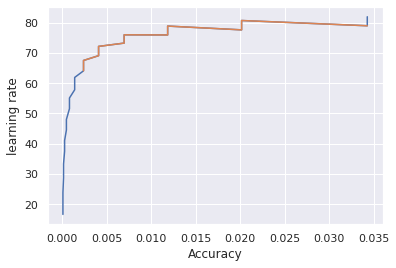

In [28]:
(lr,acc) = learning_rate
plt.plot(lr,acc)
plt.plot(lr[12:-1],acc[12:-1])
plt.ylabel('learning rate')
plt.xlabel('Accuracy')
print('Best ACC and Learning Rate are', max(lr), max(acc))

Epochs = 24, 
batch size = 512
number of batchs per epoch = 50k/512 = 98

Max at 5 epochs - 5*98 = 490 step. 


In [ ]:
len(train_loader)

98

# Learning Rate Finder - Increase the learning rate from low value to high value. 

Plot learning rate vs accuracy to come up with max learning rate. 

In [20]:
# one cycle LR

from torch.optim.lr_scheduler import OneCycleLR

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9, nesterov=False)

# scheduler =OneCycleLR(optimizer, max_lr=ideal_lr*10, steps_per_epoch=1,
#                       epochs=EPOCHS,div_factor = 10,final_div_factor=1,pct_start=5/EPOCHS,
#                       anneal_strategy="linear")#,cycle_momentum=False,div_factor = 10, final_div_factor = 1)


scheduler =OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=10,
                      epochs=EPOCHS,div_factor = 1000,final_div_factor=1,pct_start=5/EPOCHS,
                      anneal_strategy="linear")#,cycle_momentum=False,div_factor = 10, final_div_factor = 1)

    # change the steps per epoch to 1 later               

# scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(data.train_loader),
#                        epochs=args.epochs, div_factor=10, final_div_factor=1,
#                        pct_start=5/args.epochs, anneal_strategy="linear")

In [21]:
# lr_list =[]
# for i in range(EPOCHS):
#   # print('EPOCH',i)
#   print(optimizer.param_groups[0]['lr'])
#   lr_list.append(optimizer.param_groups[0]['lr'])
#   optimizer.step()
#   scheduler.step()
# plt.plot(lr_list) 

In [ ]:
# # Uses Reduce on plateu option for changing the learning rate
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9, nesterov=False)
# scheduler = ReduceLROnPlateau(optimizer, patience = 3)
# # scheduler = StepLR(optimizer, step_size=6, gamma=0.05)

In [22]:
exp_name = 'Resnet'

trainer = Test_Train_OCP.Trainer(model,device,train_loader,test_loader,optimizer,start_epoch,EPOCHS,scheduler,model_save_path,best_acc)
# train_metric, test_metric = trainer.train(l1_lambda=0, l2_lambda=0)
train_metric, test_metric,learning_rate = trainer.train(l1_lambda=0, l2_lambda=0)


# save the metrics in dictionary
metric_values[exp_name] = (train_metric, test_metric)

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0
learning rate  5e-05


/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
Loss=2.1791017055511475 Batch_id=97 Accuracy=16.00: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1360, Accuracy: 2212/10000 (22.12%)

emptying the cache
EPOCH: 1
learning rate  0.0010693877551020408


Loss=1.4972716569900513 Batch_id=97 Accuracy=35.66: 100%|██████████| 98/98 [00:55<00:00,  1.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4813, Accuracy: 4499/10000 (44.99%)

EPOCH: 2
learning rate  0.002088775510204082


Loss=1.3143641948699951 Batch_id=97 Accuracy=49.78: 100%|██████████| 98/98 [00:56<00:00,  1.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2633, Accuracy: 5350/10000 (53.50%)

EPOCH: 3
learning rate  0.0031081632653061227


Loss=1.066482424736023 Batch_id=97 Accuracy=58.31: 100%|██████████| 98/98 [00:56<00:00,  1.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0753, Accuracy: 6201/10000 (62.01%)

EPOCH: 4
learning rate  0.004127551020408163


Loss=0.8979699015617371 Batch_id=97 Accuracy=65.57: 100%|██████████| 98/98 [00:57<00:00,  1.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1259, Accuracy: 6235/10000 (62.35%)

EPOCH: 5
learning rate  0.005146938775510204


Loss=0.7427275776863098 Batch_id=97 Accuracy=70.36: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9177, Accuracy: 6902/10000 (69.02%)

EPOCH: 6
learning rate  0.006166326530612245


Loss=0.7161480784416199 Batch_id=97 Accuracy=74.04: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0184, Accuracy: 6755/10000 (67.55%)

EPOCH: 7
learning rate  0.007185714285714285


Loss=0.6276346445083618 Batch_id=97 Accuracy=76.80: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7346, Accuracy: 7520/10000 (75.20%)

EPOCH: 8
learning rate  0.008205102040816327


Loss=0.6120732426643372 Batch_id=97 Accuracy=78.98: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6750, Accuracy: 7644/10000 (76.44%)

EPOCH: 9
learning rate  0.009224489795918368


Loss=0.5650724768638611 Batch_id=97 Accuracy=80.57: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6968, Accuracy: 7684/10000 (76.84%)

EPOCH: 10
learning rate  0.010243877551020408


Loss=0.4795765280723572 Batch_id=97 Accuracy=82.08: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6652, Accuracy: 7841/10000 (78.41%)

emptying the cache
EPOCH: 11
learning rate  0.011263265306122448


Loss=0.5186342597007751 Batch_id=97 Accuracy=83.27: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Accuracy: 8134/10000 (81.34%)

EPOCH: 12
learning rate  0.01228265306122449


Loss=0.46020254492759705 Batch_id=97 Accuracy=84.37: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5474, Accuracy: 8235/10000 (82.35%)

EPOCH: 13
learning rate  0.013302040816326532


Loss=0.44180673360824585 Batch_id=97 Accuracy=85.44: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5289, Accuracy: 8241/10000 (82.41%)

EPOCH: 14
learning rate  0.01432142857142857


Loss=0.38256773352622986 Batch_id=97 Accuracy=86.58: 100%|██████████| 98/98 [00:57<00:00,  1.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5721, Accuracy: 8252/10000 (82.52%)

EPOCH: 15
learning rate  0.015340816326530613


Loss=0.3361130654811859 Batch_id=97 Accuracy=87.60: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5757, Accuracy: 8233/10000 (82.33%)

EPOCH: 16
learning rate  0.016360204081632655


Loss=0.38125595450401306 Batch_id=97 Accuracy=87.86: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5794, Accuracy: 8200/10000 (82.00%)

EPOCH: 17
learning rate  0.017379591836734695


Loss=0.30211836099624634 Batch_id=97 Accuracy=88.50: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6794, Accuracy: 7943/10000 (79.43%)

EPOCH: 18
learning rate  0.01839897959183674


Loss=0.23702137172222137 Batch_id=97 Accuracy=89.12: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5951, Accuracy: 8244/10000 (82.44%)

EPOCH: 19
learning rate  0.019418367346938775


Loss=0.271456778049469 Batch_id=97 Accuracy=89.50: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6864, Accuracy: 8119/10000 (81.19%)

EPOCH: 20
learning rate  0.02043775510204082


Loss=0.31142520904541016 Batch_id=97 Accuracy=90.66: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7331, Accuracy: 8000/10000 (80.00%)

emptying the cache
EPOCH: 21
learning rate  0.02145714285714286


Loss=0.20580314099788666 Batch_id=97 Accuracy=90.99: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6468, Accuracy: 8176/10000 (81.76%)

EPOCH: 22
learning rate  0.0224765306122449


Loss=0.29209572076797485 Batch_id=97 Accuracy=91.44: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6151, Accuracy: 8345/10000 (83.45%)

EPOCH: 23
learning rate  0.023495918367346942


Loss=0.2941148281097412 Batch_id=97 Accuracy=91.66: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5046, Accuracy: 8504/10000 (85.04%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 24
learning rate  0.024515306122448982


Loss=0.27099326252937317 Batch_id=97 Accuracy=91.98: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7063, Accuracy: 8254/10000 (82.54%)

EPOCH: 25
learning rate  0.025534693877551022


Loss=0.24844828248023987 Batch_id=97 Accuracy=92.47: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5367, Accuracy: 8542/10000 (85.42%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 26
learning rate  0.026554081632653066


Loss=0.21506193280220032 Batch_id=97 Accuracy=92.87: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7313, Accuracy: 8167/10000 (81.67%)

EPOCH: 27
learning rate  0.027573469387755102


Loss=0.14498770236968994 Batch_id=97 Accuracy=93.51: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6297, Accuracy: 8347/10000 (83.47%)

EPOCH: 28
learning rate  0.028592857142857142


Loss=0.25179657340049744 Batch_id=97 Accuracy=93.58: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7410, Accuracy: 8257/10000 (82.57%)

EPOCH: 29
learning rate  0.029612244897959186


Loss=0.26580408215522766 Batch_id=97 Accuracy=93.89: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6567, Accuracy: 8430/10000 (84.30%)

EPOCH: 30
learning rate  0.03063163265306123


Loss=0.0892440676689148 Batch_id=97 Accuracy=94.02: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5641, Accuracy: 8496/10000 (84.96%)

emptying the cache
EPOCH: 31
learning rate  0.03165102040816327


Loss=0.20789098739624023 Batch_id=97 Accuracy=93.98: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5802, Accuracy: 8489/10000 (84.89%)

EPOCH: 32
learning rate  0.03267040816326531


Loss=0.13548386096954346 Batch_id=97 Accuracy=94.62: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5013, Accuracy: 8685/10000 (86.85%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 33
learning rate  0.03368979591836735


Loss=0.1306155025959015 Batch_id=97 Accuracy=94.47: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5871, Accuracy: 8547/10000 (85.47%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 34
learning rate  0.03470918367346939


Loss=0.15177816152572632 Batch_id=97 Accuracy=95.00: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5666, Accuracy: 8587/10000 (85.87%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 35
learning rate  0.03572857142857143


Loss=0.16366197168827057 Batch_id=97 Accuracy=95.03: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.5994, Accuracy: 8533/10000 (85.33%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 36
learning rate  0.036747959183673476


Loss=0.1336657702922821 Batch_id=97 Accuracy=95.14: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.4372, Accuracy: 8780/10000 (87.80%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 37
learning rate  0.03776734693877551


Loss=0.18305417895317078 Batch_id=97 Accuracy=95.37: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6797, Accuracy: 8357/10000 (83.57%)

EPOCH: 38
learning rate  0.03878673469387755


Loss=0.10213567316532135 Batch_id=97 Accuracy=95.54: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5795, Accuracy: 8629/10000 (86.29%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 39
learning rate  0.039806122448979596


Loss=0.12104695290327072 Batch_id=97 Accuracy=95.46: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5159, Accuracy: 8645/10000 (86.45%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 40
learning rate  0.040825510204081636


Loss=0.11665499955415726 Batch_id=97 Accuracy=95.50: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5798, Accuracy: 8609/10000 (86.09%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
emptying the cache
EPOCH: 41
learning rate  0.041844897959183676


Loss=0.14942581951618195 Batch_id=97 Accuracy=95.90: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5647, Accuracy: 8667/10000 (86.67%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 42
learning rate  0.042864285714285716


Loss=0.08501819521188736 Batch_id=97 Accuracy=95.88: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.6220, Accuracy: 8610/10000 (86.10%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 43
learning rate  0.043883673469387756


Loss=0.06348679959774017 Batch_id=97 Accuracy=96.05: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5737, Accuracy: 8728/10000 (87.28%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 44
learning rate  0.044903061224489796


Loss=0.10535638779401779 Batch_id=97 Accuracy=96.24: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.5112, Accuracy: 8767/10000 (87.67%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 45
learning rate  0.04592244897959184


Loss=0.10789307206869125 Batch_id=97 Accuracy=96.43: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5145, Accuracy: 8799/10000 (87.99%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 46
learning rate  0.04694183673469388


Loss=0.12972073256969452 Batch_id=97 Accuracy=96.36: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.6008, Accuracy: 8681/10000 (86.81%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 47
learning rate  0.047961224489795916


Loss=0.11604641377925873 Batch_id=97 Accuracy=96.28: 100%|██████████| 98/98 [00:57<00:00,  1.69it/s]



Test set: Average loss: 0.5650, Accuracy: 8684/10000 (86.84%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 48
learning rate  0.04898061224489796


Loss=0.09948243200778961 Batch_id=97 Accuracy=96.31: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5694, Accuracy: 8653/10000 (86.53%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
EPOCH: 49
learning rate  0.05


Loss=0.09865362197160721 Batch_id=97 Accuracy=96.58: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.5522, Accuracy: 8714/10000 (87.14%)

...BEST MODEL...
Save success...


Best ACC and Learning Rate are 0.05 96.576


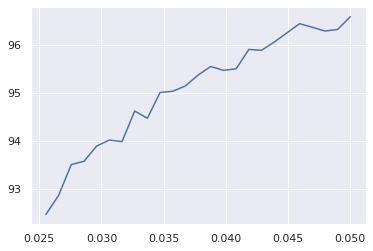

In [26]:
(lr,acc) = learning_rate
plt.plot(lr[25:],acc[25:])
print('Best ACC and Learning Rate are', max(lr), max(acc))

In [ ]:
# one cycle LR

from torch.optim.lr_scheduler import OneCycleLR

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=ideal_lr, momentum=0.9, nesterov=False)

# scheduler =OneCycleLR(optimizer, max_lr=ideal_lr*10, steps_per_epoch=1,
#                       epochs=EPOCHS,div_factor = 10,final_div_factor=1,pct_start=5/EPOCHS,
#                       anneal_strategy="linear")#,cycle_momentum=False,div_factor = 10, final_div_factor = 1)


scheduler =OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=10,
                      epochs=EPOCHS,div_factor = 1000,final_div_factor=1,pct_start=5/EPOCHS,
                      anneal_strategy="linear")#,cycle_momentum=False,div_factor = 10, final_div_factor = 1)

    # change the steps per epoch to 1 later               

# scheduler = OneCycleLR(optimizer, max_lr=best_lr, steps_per_epoch=len(data.train_loader),
#                        epochs=args.epochs, div_factor=10, final_div_factor=1,
#                        pct_start=5/args.epochs, anneal_strategy="linear")

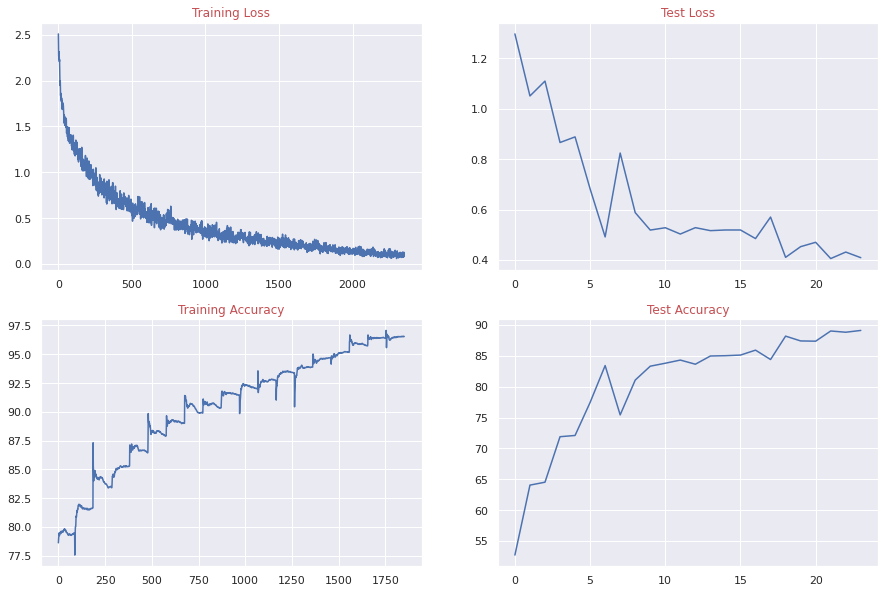

In [ ]:
Plots.plot_metrics(train_metric, test_metric)

# Plot misclassified

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)


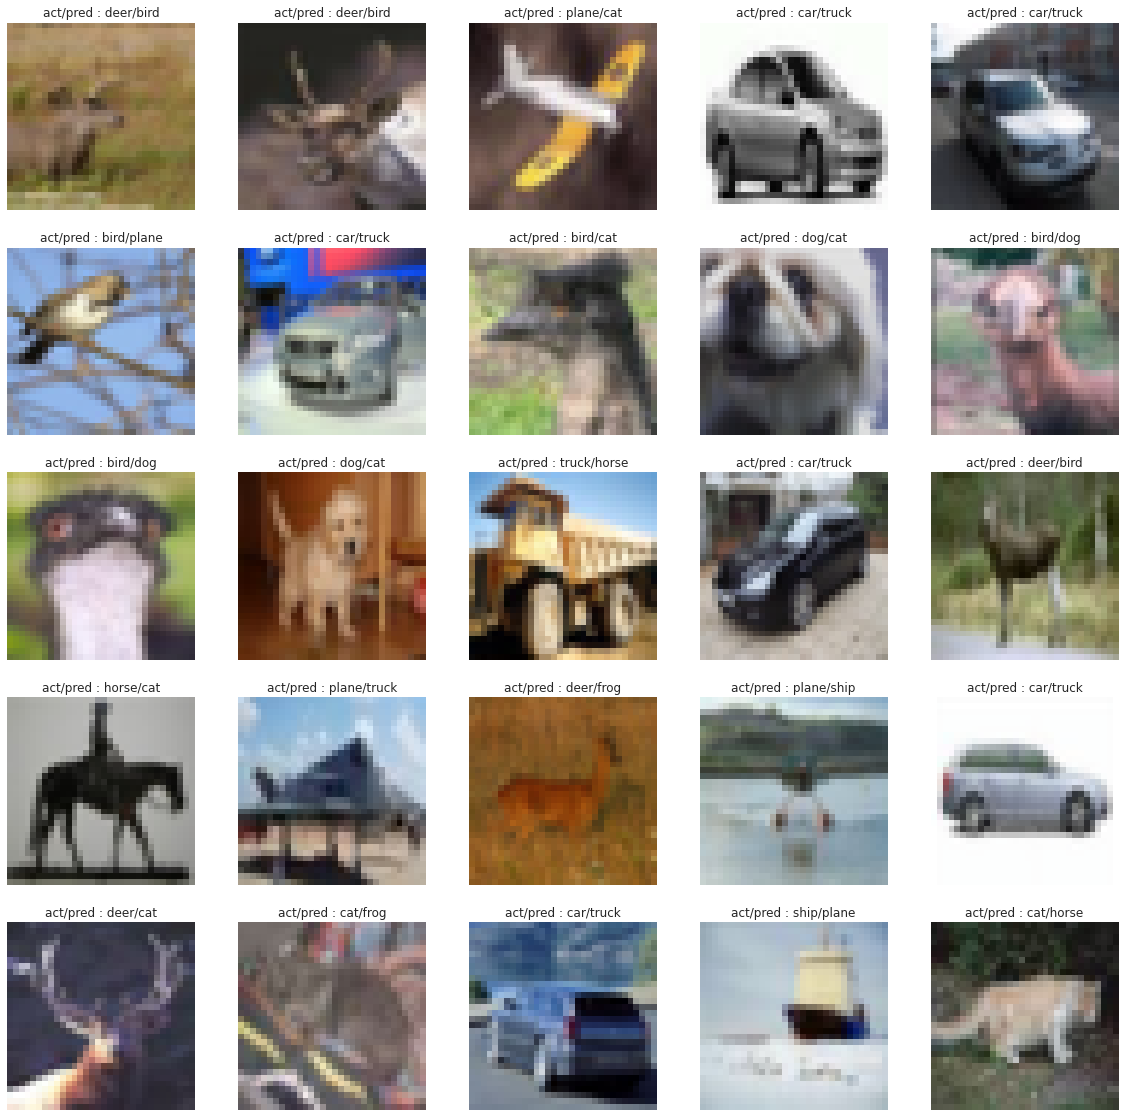

In [ ]:
misclass_img_list = plot_misclassified(model, test_loader, device,classes)

In [ ]:
len(misclass_img_list)

25

In [ ]:
mis_img_name_list = save_misclassified(misclass_img_list)
pil_image = download_img_pil(mis_img_name_list)
torch_img_list,normed_torch_img = pil_img_transform(pil_image,device)

In [ ]:
len(mis_img_name_list), len(pil_image), len(torch_img_list)

(25, 25, 25)

/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/11_Super-Convergence/Resnet.py:109: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


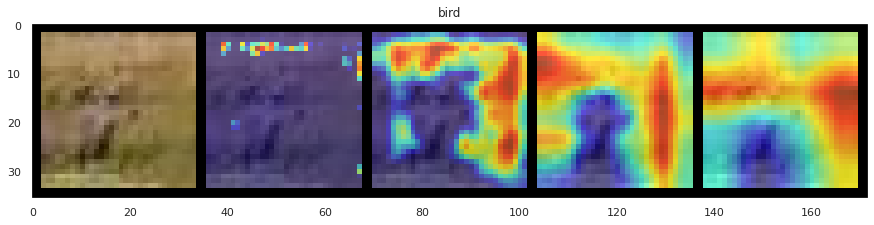

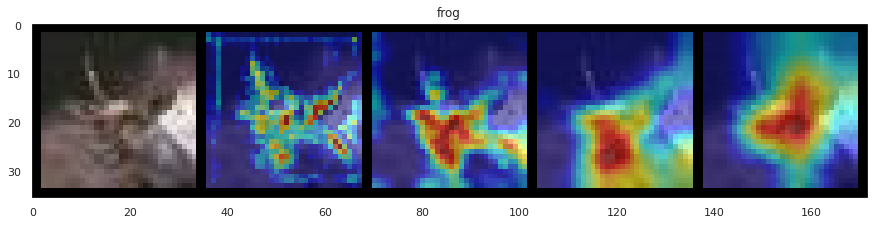

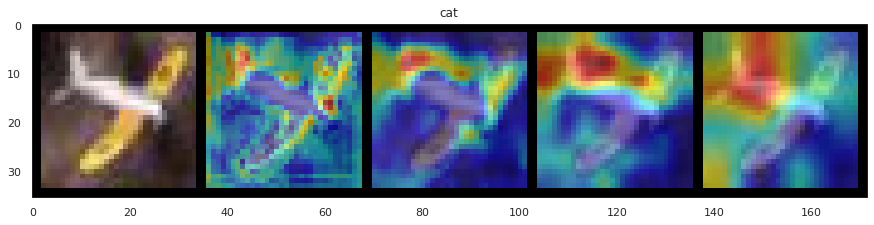

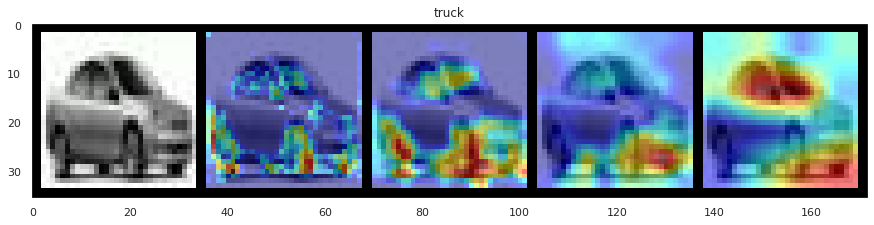

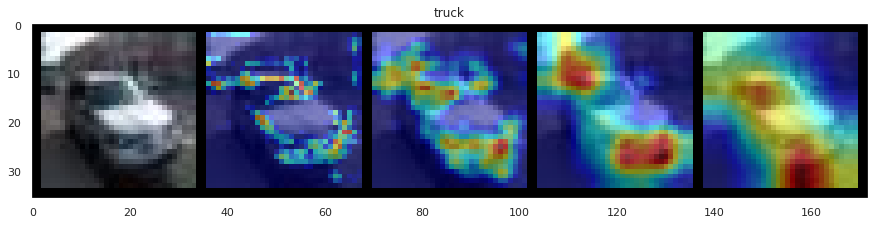

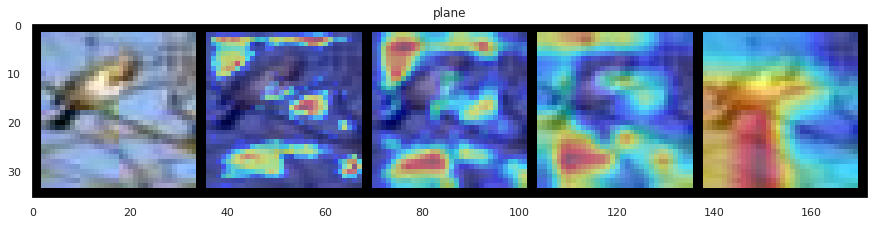

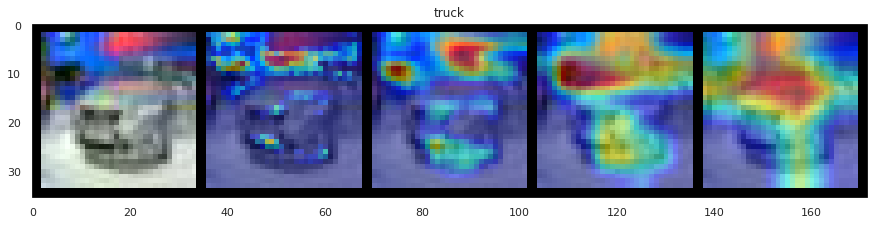

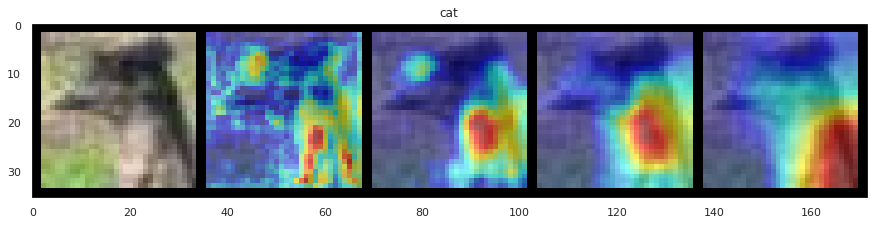

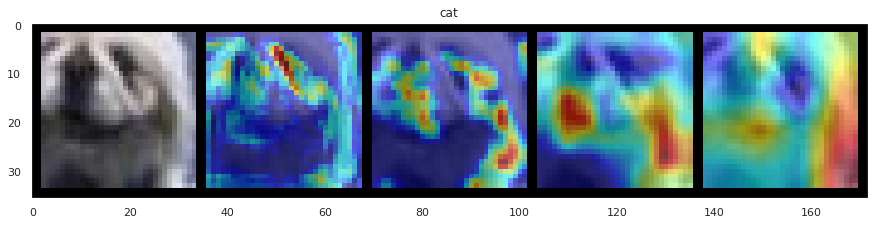

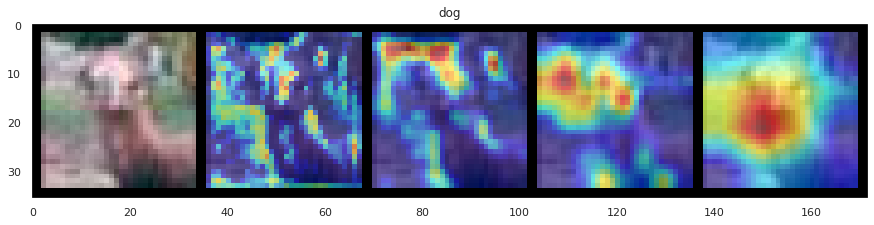

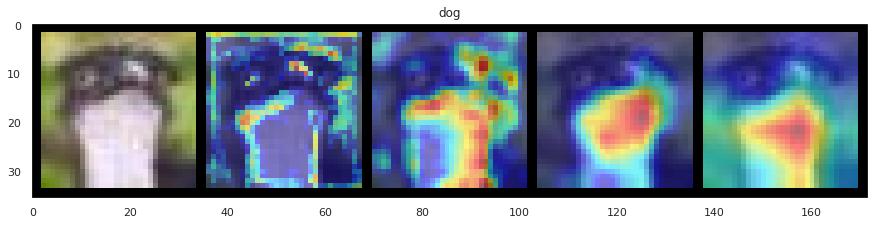

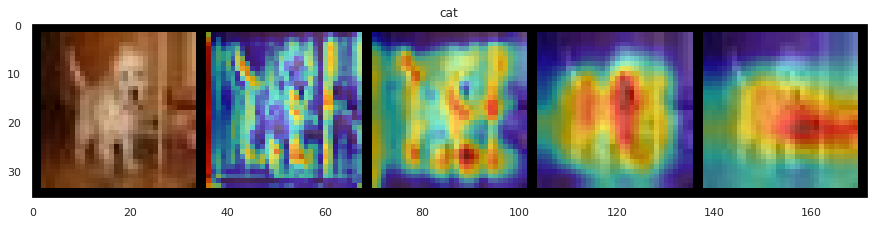

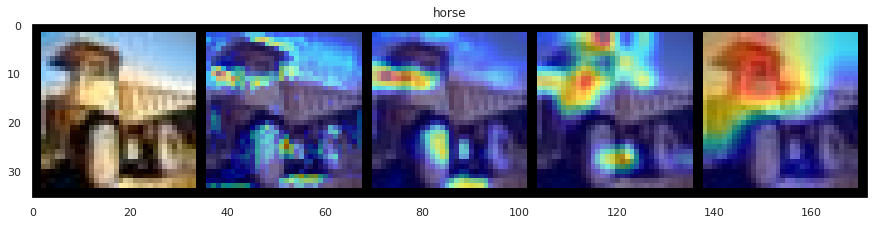

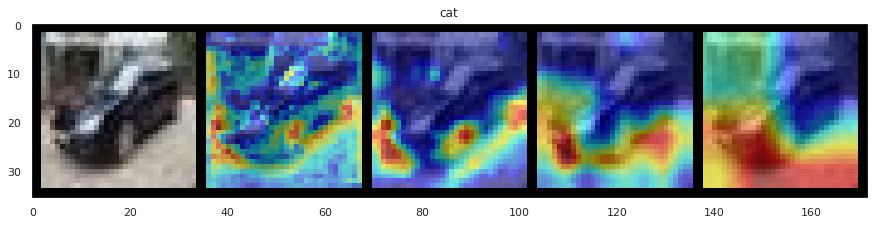

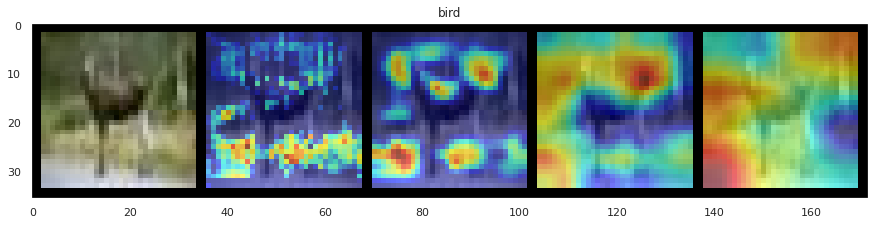

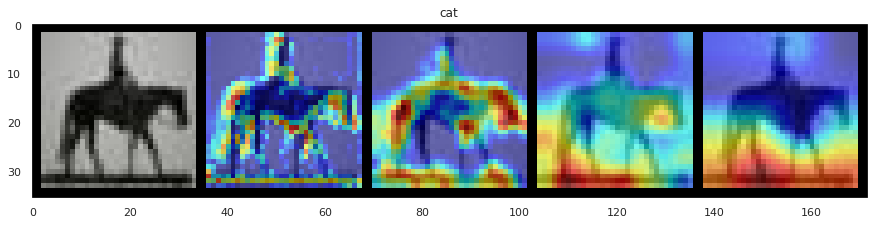

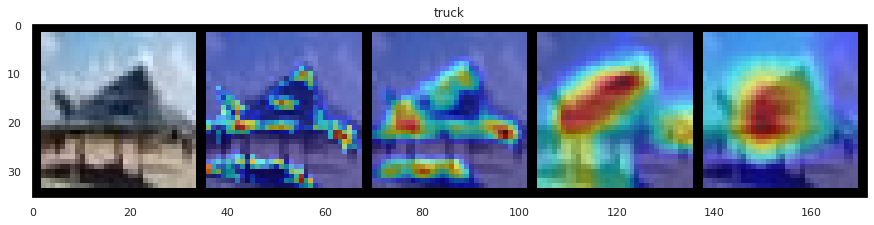

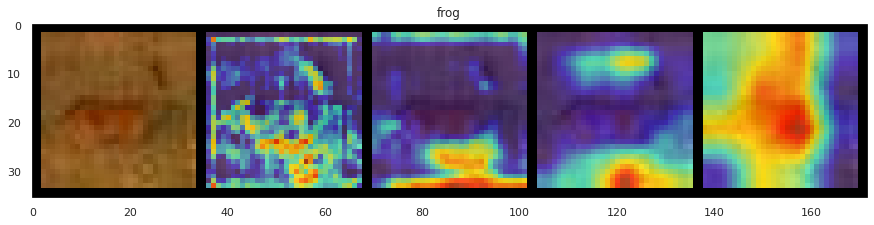

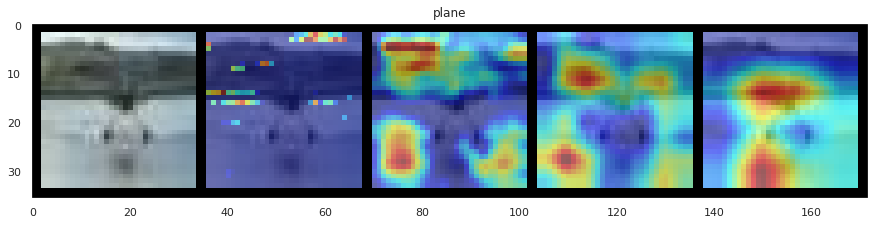

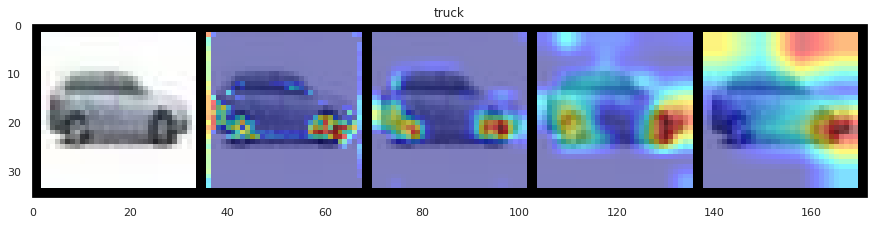

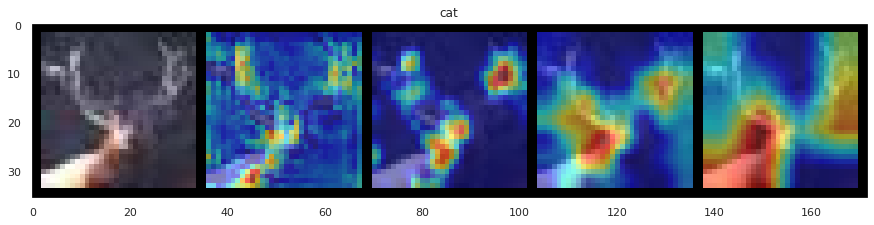

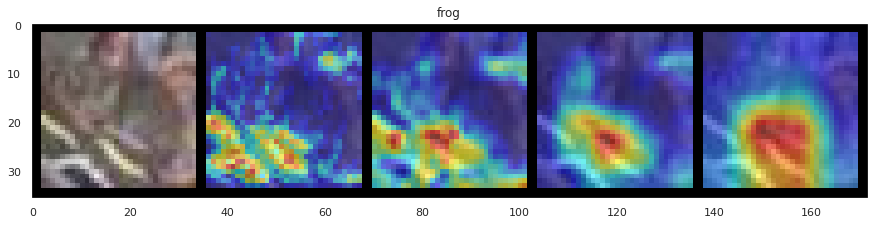

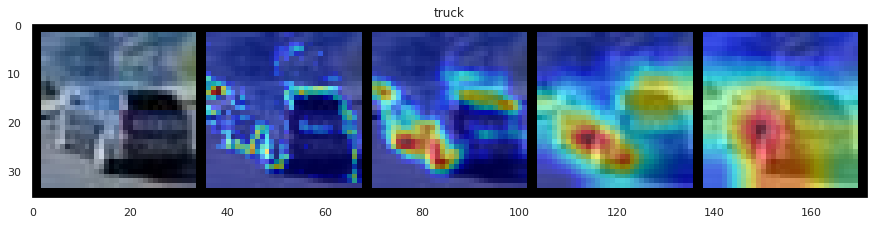

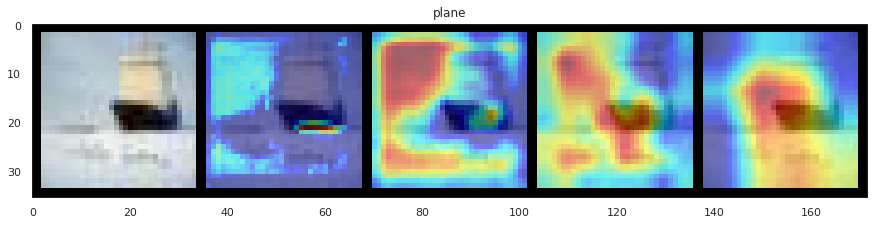

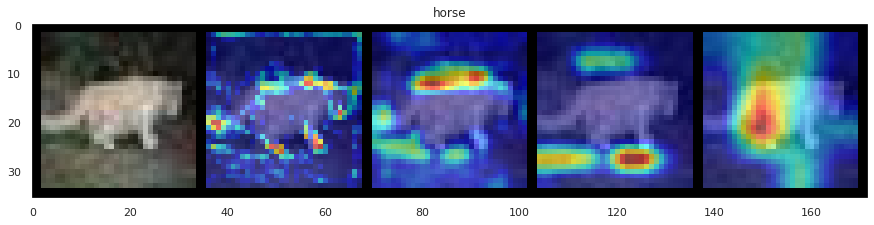

In [ ]:

import copy
from torchvision.utils import make_grid, save_image

for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(model.to(device))
  output = model(normed_torch_img[i])
  _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
    

  grid_image = make_grid(images2,nrow=5,padding=2,normalize=False)

  imshow1(grid_image,c = classes[int(predicted)])